In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from sentence_transformers import SentenceTransformer, util
# import torch
# import mplcursors
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
import json
from langchain.chains.summarize import load_summarize_chain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
import tiktoken
from langchain.docstore.document import Document
from langchain.text_splitter import CharacterTextSplitter


import textwrap
from time import monotonic

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', '00', 'no2', 'no3'])

In [31]:
df = pd.read_csv('../data/combined_df.csv')
df.columns

Index(['email', 'first_name', 'last_name', 'faculty', 'department',
       'area_of_focus', 'gs_link', 'author_id', 'title', 'abstract', 'doi',
       'gs_url', 'embeddings', 'umap_x', 'umap_y', 'cluster', 'kde',
       'top_keywords', 'department_broad', 'focus_label', 'focus_tag'],
      dtype='object')

In [34]:
# Calculate the statistics
unique_name_count = df['first_name'].str.cat(df['last_name'], sep=' ').nunique()
entry_count = df.shape[0]
unique_department_count = df['department_broad'].nunique()
unique_faculty_count = df['faculty'].nunique()

print(f"Number of unique names: {unique_name_count}")
print(f"Number of entries: {entry_count}")
print(f"Number of unique departments: {unique_department_count}")
print(f"Number of unique faculties: {unique_faculty_count}")

Number of unique names: 191
Number of entries: 2872
Number of unique departments: 8
Number of unique faculties: 6


In [2]:
df = pd.read_csv('../raw_data/ieee_vis.csv')
df.sample(3)

,Conference,Year,Title,DOI,Link,FirstPage,LastPage,PaperType,Abstract,AuthorNames-Deduped,AuthorNames,AuthorAffiliation,InternalReferences,AuthorKeywords,AminerCitationCount,CitationCount_CrossRef,PubsCited_CrossRef,Downloads_Xplore,Award,GraphicsReplicabilityStamp
1705,Vis,2009,Loop surgery for volumetric meshes: Reeb graph...,10.1109/tvcg.2009.163,http://dx.doi.org/10.1109/TVCG.2009.163,1177.0,1184.0,J,This paper introduces an efficient algorithm f...,Julien Tierny;Attila Gyulassy;Eddie Simon;Vale...,Julien Tierny;Attila Gyulassy;Eddie Simon;Vale...,"Scientific Computing and Imaging Institute, Un...",0.1109/visual.2004.96;10.1109/tvcg.2007.70601;...,"Reeb graph, scalar field topology, isosurfaces...",121.0,65.0,29.0,423.0,NaN,NaN
3509,Vis,1992,Interactive terrain rendering and volume visua...,10.1109/visual.1992.235189,http://dx.doi.org/10.1109/VISUAL.1992.235189,349.0,355.0,C,The implementation of truly interactive volume...,James T. Kaba;James R. Matey;Gordon Stoll;Herb...,J. Kaba;J. Matey;G. Stoll;H. Taylor;P. Hanrahan,"David Sarnoff Research Center, National Inform...",0.1109/visual.1991.175778;10.1109/visual.1991....,NaN,NaN,9.0,28.0,46.0,NaN,NaN
2503,Vis,2003,A novel interface for higher-dimensional class...,10.1109/visual.2003.1250413,http://dx.doi.org/10.1109/VISUAL.2003.1250413,505.0,512.0,C,In the traditional volume visualization paradi...,Fan-Yin Tzeng;Eric B. Lum;Kwan-Liu Ma,Fan-Yin Tzeng;E.B. Lum;Kwan-Liu Ma,"Department of Computer Science, University of ...",0.1109/visual.1998.745319;10.1109/visual.2001....,"classification, graphics hardware, interactive...",193.0,35.0,25.0,254.0,NaN,NaN


In [3]:
df.columns

Index(['Conference', 'Year', 'Title', 'DOI', 'Link', 'FirstPage', 'LastPage',
       'PaperType', 'Abstract', 'AuthorNames-Deduped', 'AuthorNames',
       'AuthorAffiliation', 'InternalReferences', 'AuthorKeywords',
       'AminerCitationCount', 'CitationCount_CrossRef', 'PubsCited_CrossRef',
       'Downloads_Xplore', 'Award', 'GraphicsReplicabilityStamp'],
      dtype='object')

In [6]:
# embed
df = df.dropna(subset=['Abstract'])
df['Abstract'] = df['Abstract'].fillna('')

model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode all 25k reviews
BATCH_SIZE = 128
embeddings = model.encode(df['Abstract'].values.tolist(), batch_size=BATCH_SIZE, show_progress_bar=True)
df['embeddings'] = embeddings.tolist()

# UMAP
umap = UMAP(n_neighbors=15, n_components=2, metric='cosine')
umap_embeddings = umap.fit_transform(embeddings)
df['umap_x'] = umap_embeddings[:, 0]
df['umap_y'] = umap_embeddings[:, 1]

Batches:   0%|          | 0/29 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
# cluster embeddings
num_clusters = 10
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embeddings)
cluster_assignment = clustering_model.labels_
df['cluster'] = cluster_assignment

# top keywords
def get_top_keywords(data, cluster, n_keywords):
    df_cluster = data[data['cluster'] == cluster]
    vectorizer = TfidfVectorizer(stop_words=stop_words)
    X = vectorizer.fit_transform(df_cluster['Abstract'])
    keywords = np.array(vectorizer.get_feature_names_out())
    tfidf_sorting = np.argsort(X.toarray()).flatten()[::-1]
    top_n = keywords[tfidf_sorting][:n_keywords]
    return top_n

# get top keywords for each cluster
n_keywords = 10
cluster_keywords = []
for cluster in range(num_clusters):
    cluster_keywords.append(get_top_keywords(df, cluster, n_keywords))
    

df['top_keywords'] = df['cluster'].apply(lambda cluster: cluster_keywords[cluster])

In [15]:
df['top_keywords'].iloc[0]

array(['palettes', 'color', 'nl2color', 'palette', 'triplets', 'revised',
       'mathrm', 'editing', 'intentions', 'desired'], dtype=object)

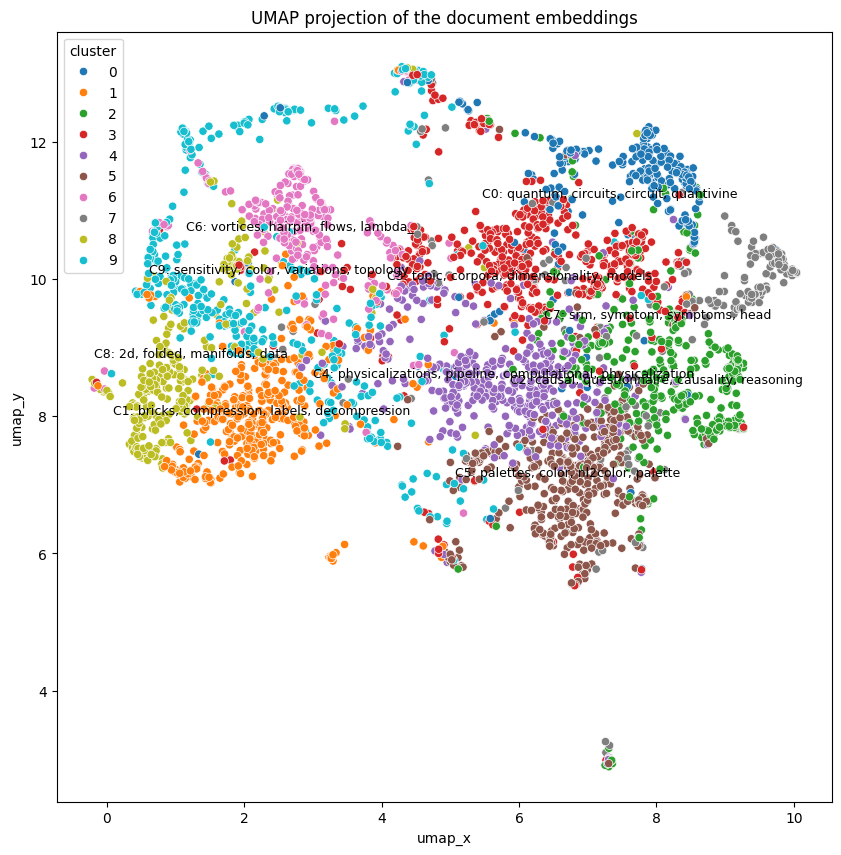

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='umap_x', y='umap_y', hue='cluster', data=df, palette='tab10', ax=ax)

# contourf
# KernelDensity
# x = df['embeddings'].apply(lambda x: x[0]).values
# y = df['embeddings'].apply(lambda x: x[1]).values
# xx, yy = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
# positions = np.vstack([xx.ravel(), yy.ravel()])
# values = np.vstack([x, y])
# kernel = KernelDensity(bandwidth=0.5, metric='euclidean', kernel='gaussian')
# kernel.fit(values.T)
# f = np.reshape(np.exp(kernel.score_samples(positions.T)), xx.shape)

# ax.contourf(xx, yy, f, cmap='Blues', alpha=0.3)
ax.set_title('UMAP projection of the document embeddings')


# legend showing top_keywords
for cluster in range(10):
    keywords = df[df['cluster'] == cluster]['top_keywords'].values[0][:4]
    # keywords = keywords.split(',')[:4]
    if len(keywords) > 0:
        # based on umap_x, y's mean position
        x_mean = df[df['cluster'] == cluster]['umap_x'].mean()
        y_mean = df[df['cluster'] == cluster]['umap_y'].mean()
        
        ax.text(x_mean, y_mean, f'C{cluster}: {", ".join(keywords)}', fontsize=9, color='black', ha='center')

plt.show()

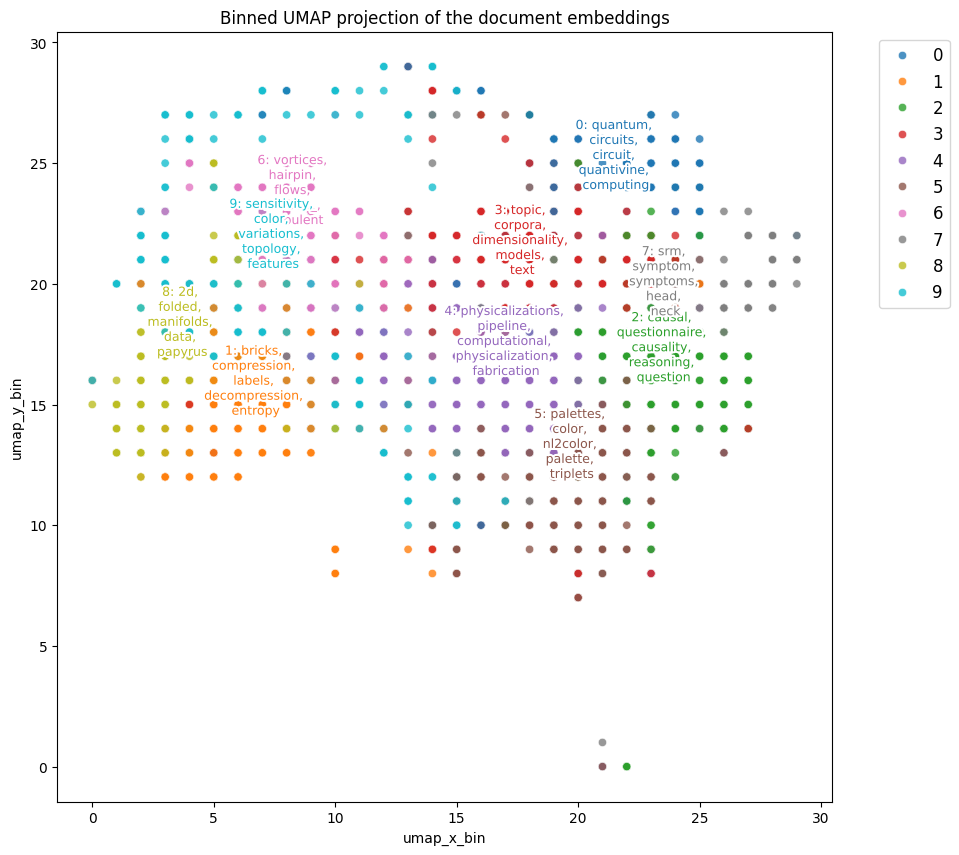

In [27]:
from matplotlib import patheffects

palette = sns.color_palette('tab10', 10)

BINS_NUM = 30

# a range from 10 to 20 with 2 steps
for bin in range(10, 40, 2):
    df[f'umap_x_bin_{bin}'] = pd.cut(df['umap_x'], bins=bin, labels=False)
    df[f'umap_y_bin_{bin}'] = pd.cut(df['umap_y'], bins=bin, labels=False)

df['umap_x_bin'] = pd.cut(df['umap_x'], bins=BINS_NUM, labels=False)
df['umap_y_bin'] = pd.cut(df['umap_y'], bins=BINS_NUM, labels=False)
df['bin_id'] = df.apply(lambda x: f'{x["umap_x_bin"]}_{x["umap_y_bin"]}', axis=1)

plt.figure(figsize=(10, 10))

# plot binning data, larger dots represent more messages in the bin
sns.scatterplot(x='umap_x_bin', y='umap_y_bin', data=df, sizes=(20, 200), legend=True, alpha=0.8, hue='cluster', palette=palette)


for cluster in range(10):
    keywords = df[df['cluster'] == cluster]['top_keywords'].values[0][:5]
    if len(keywords) > 0:
        # based on umap_x, y's mean position
        x_mean = df[df['cluster'] == cluster]['umap_x_bin'].mean()
        y_mean = df[df['cluster'] == cluster]['umap_y_bin'].mean()
        
        # plt.text(x_mean, y_mean, f'C{cluster}: {",".join(keywords)}', fontsize=9, color='black', ha='center')
        cluster_color = palette[cluster]
        plt.text(x_mean, y_mean, f'{cluster}: ' + ", \n".join(keywords), fontsize=9, color=cluster_color, ha='center',
                 path_effects=[patheffects.withStroke(linewidth=3, foreground='w')])

    
    
plt.title('Binned UMAP projection of the document embeddings')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)

plt.show()

In [28]:
df.to_csv('../data/ieee_vis_embed.csv', index=False)

In [18]:
df.columns

Index(['email', 'first_name', 'last_name', 'faculty', 'department',
       'area_of_focus', 'gs_link', 'author_id', 'title', 'abstract', 'doi',
       'gs_url', 'embeddings', 'umap_x', 'umap_y', 'cluster', 'kde',
       'top_keywords', 'department_broad', 'focus_label', 'focus_tag',
       'umap_x_bin_10', 'umap_y_bin_10', 'umap_x_bin_12', 'umap_y_bin_12',
       'umap_x_bin_14', 'umap_y_bin_14', 'umap_x_bin_16', 'umap_y_bin_16',
       'umap_x_bin_18', 'umap_y_bin_18', 'umap_x_bin', 'umap_y_bin',
       'umap_x_bin_20', 'umap_y_bin_20', 'umap_x_bin_22', 'umap_y_bin_22',
       'umap_x_bin_24', 'umap_y_bin_24', 'umap_x_bin_26', 'umap_y_bin_26',
       'umap_x_bin_28', 'umap_y_bin_28', 'umap_x_bin_30', 'umap_y_bin_30',
       'umap_x_bin_32', 'umap_y_bin_32', 'umap_x_bin_34', 'umap_y_bin_34',
       'umap_x_bin_36', 'umap_y_bin_36', 'umap_x_bin_38', 'umap_y_bin_38',
       'bin_id'],
      dtype='object')